In [1]:
### plotting
import matplotlib.pyplot as plt

### user module
from model.transit_sim_model import Network, Trains, Travelers

### fix random seed
import numpy as np
np.random.seed(0)

### Process GTFS schedules
Need the following tables:
 * stop_times.txt: schedule info
 * trips.txt: map trip_id to route_id
 * stops.txt: get stop coordinates (for visualization)

In [2]:
### read in GTFS files
stop_times_file = 'example_bart_google_transit_20211101_20220213_v2/stop_times.txt'
trips_file = 'example_bart_google_transit_20211101_20220213_v2/trips.txt'
stops_file = 'example_bart_google_transit_20211101_20220213_v2/stops.txt'
### only keep results with this service id
service_id = '2021_09_13-DX-MVS-Weekday-08'

### create all trains from GTFS
all_trains = Trains()
all_nodes, all_links = all_trains.schedule_and_network_from_gtfs(
    stop_times_file, trips_file, stops_file)

### create network from nodes and links
network = Network(all_nodes, all_links)

/Users/bingyu/Desktop/transit_sim/model/transit_sim_model.py:134: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  schedule_table['stop_lon'] = schedule_table.geometry.centroid.x
/Users/bingyu/Desktop/transit_sim/model/transit_sim_model.py:135: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  schedule_table['stop_lat'] = schedule_table.geometry.centroid.y


In [3]:
### display and export network
display(network.all_nodes.head(3))
display(network.all_links.head(2))
network.all_links.to_csv('outputs/example_links.csv', index=False)
network.all_nodes.to_csv('outputs/example_nodes.csv', index=False)

,route_stop_id,stop_lon,stop_lat,stop_id,type,node_id,geometry
0,1-CONC,-122.029072,37.973757,CONC,platform,0,POINT (-122.02907 37.97376)
1,1-PHIL,-122.055971,37.928434,PHIL,platform,1,POINT (-122.05597 37.92843)
2,1-WCRK,-122.067327,37.905791,WCRK,platform,2,POINT (-122.06733 37.90579)


,route_stop_id,next_route_stop_id,start_nid,end_nid,initial_weight,geometry
38967,1-CONC,1-PHIL,0,1,1.0,"LINESTRING (-122.02907 37.97376, -122.05597 37..."
38968,1-PHIL,1-WCRK,1,2,1.0,"LINESTRING (-122.05597 37.92843, -122.06733 37..."


### Travel demand
 * random demand
 * or, input csv with columns *traveler_id*, *origin_nid*, *destin_nid*, *departure_time*

In [4]:
### random OD
### create instance
travelers = Travelers()
### generate random od
travelers.random_od(network.all_nodes, num_travelers=1)
### find routes
travelers.find_routes(network.network_g, network.station_id_nm_dict)
travelers.set_initial_status(network.station_id_nm_dict)

display(travelers.travelers_df)

,origin_nid,destin_nid,traveler_id,departure_time,traveler_status,association,next_station
0,9,22,0,26664,pretrip,None,None


In [5]:
print(travelers.travelers_paths[0])
print(travelers.travelers_key_stops[0])
all_trains.schedule_df.sort_values(by='time', ascending=True).head()

['1-WOAK', '1-EMBR', '1-MONT', '1-POWL', '1-CIVC', '1-16TH', '1-24TH', '1-GLEN', '1-BALB', '1-DALY', '1-COLM', '1-SSAN', '1-SBRN', '1-SFIA']
{'1-WOAK': '1-SFIA'}


,trip_id,time,next_time,status,location
10146,964252,16800,16830.0,stop,5-BERY
86814,1056891,16800,16830.0,stop,5-BERY
86815,1056891,16830,17040.0,on_link,5-BERY-5-MLPT
10147,964252,16830,17040.0,on_link,5-BERY-5-MLPT
86816,1056891,17040,17070.0,stop,5-MLPT


### Simulation and plotting

In [101]:
def plot_map(network, trains, travelers, t):
    
    fig, ax = plt.subplots(figsize=(20, 20))
    ### network
    network.all_links.plot(ax=ax, zorder=1)
    network.all_nodes.plot(ax=ax, zorder=2)
    ### train positions
    train_positions = trains.get_all_train_positions(network)
    train_positions.plot(ax=ax, markersize=100, facecolor="None",
         edgecolor='red', lw=1, marker='o', zorder=3)
    train_positions.apply(lambda x: ax.annotate(text=x['trip_id'], 
                                                xy=(x['geometry'].x, x['geometry'].y+np.random.random(1)/30), 
                                                ha='center'), axis=1);
    display(train_positions[train_positions['location'].isin(['1-PCTR', '2-PCTR'])])
    #display(train_positions.head())
    ### traveler positions
    traveler_locations = travelers.get_all_traveler_positions(network.station_locations, train_positions)
    #traveler_locations.plot(ax=ax, lw=traveler_locations['num_travelers'], c='green')
    
    fig.savefig('outputs/figs/t{}.png'.format(t))

,trip_id,time,next_time,status,location,current_location,geometry
1342,938066,26640,26670.0,stop,1-PCTR,current,POINT (-121.88906 38.01685)
23096,964600,26640,26670.0,stop,1-PCTR,current,POINT (-121.88906 38.01685)
48208,981087,26640,26700.0,stop,1-PCTR,current,POINT (-121.88906 38.01685)
58874,983763,26640,26670.0,stop,1-PCTR,current,POINT (-121.88906 38.01685)
69238,1056446,26640,26670.0,stop,1-PCTR,current,POINT (-121.88906 38.01685)


,trip_id,time,next_time,status,location,current_location,geometry
48208,981087,26640,26700.0,stop,1-PCTR,current,POINT (-121.88906 38.01685)


,trip_id,time,next_time,status,location,current_location,geometry


,trip_id,time,next_time,status,location,current_location,geometry


,trip_id,time,next_time,status,location,current_location,geometry


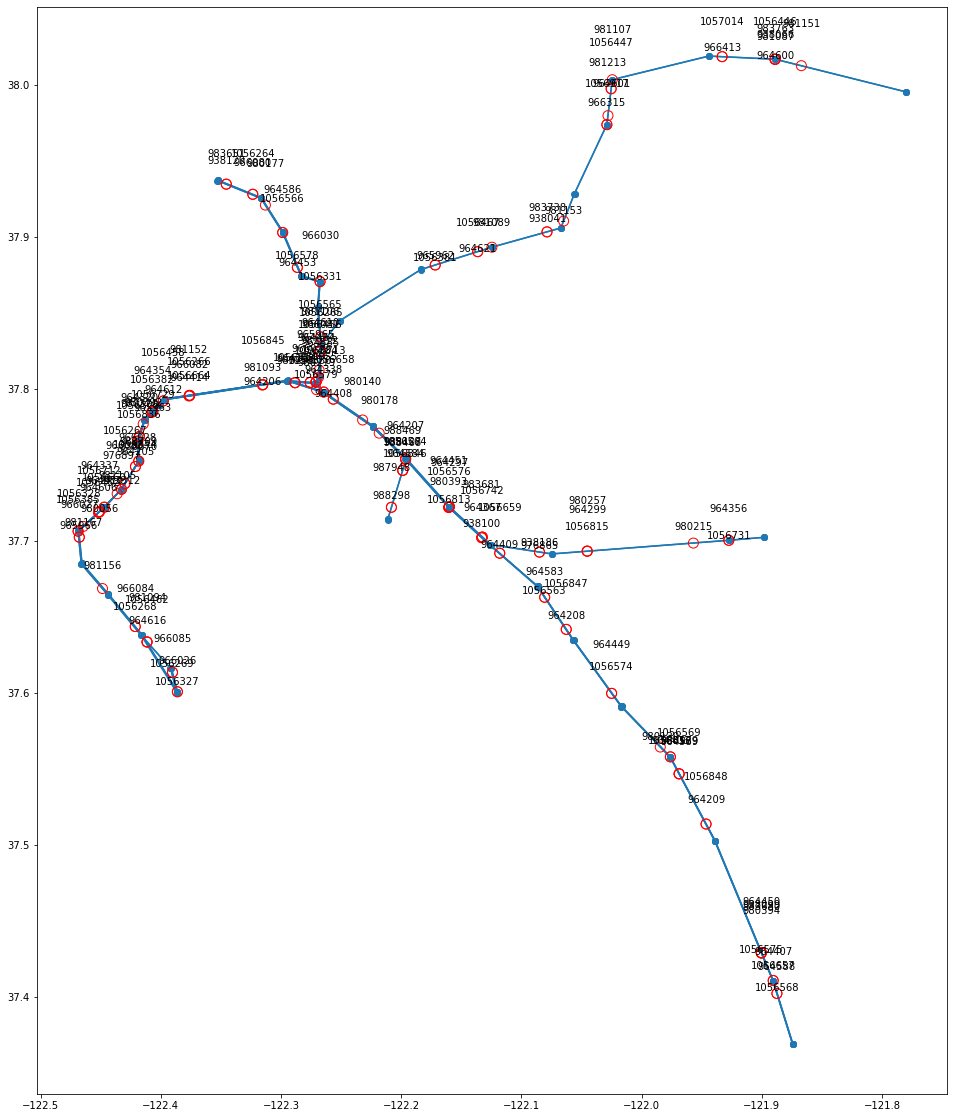

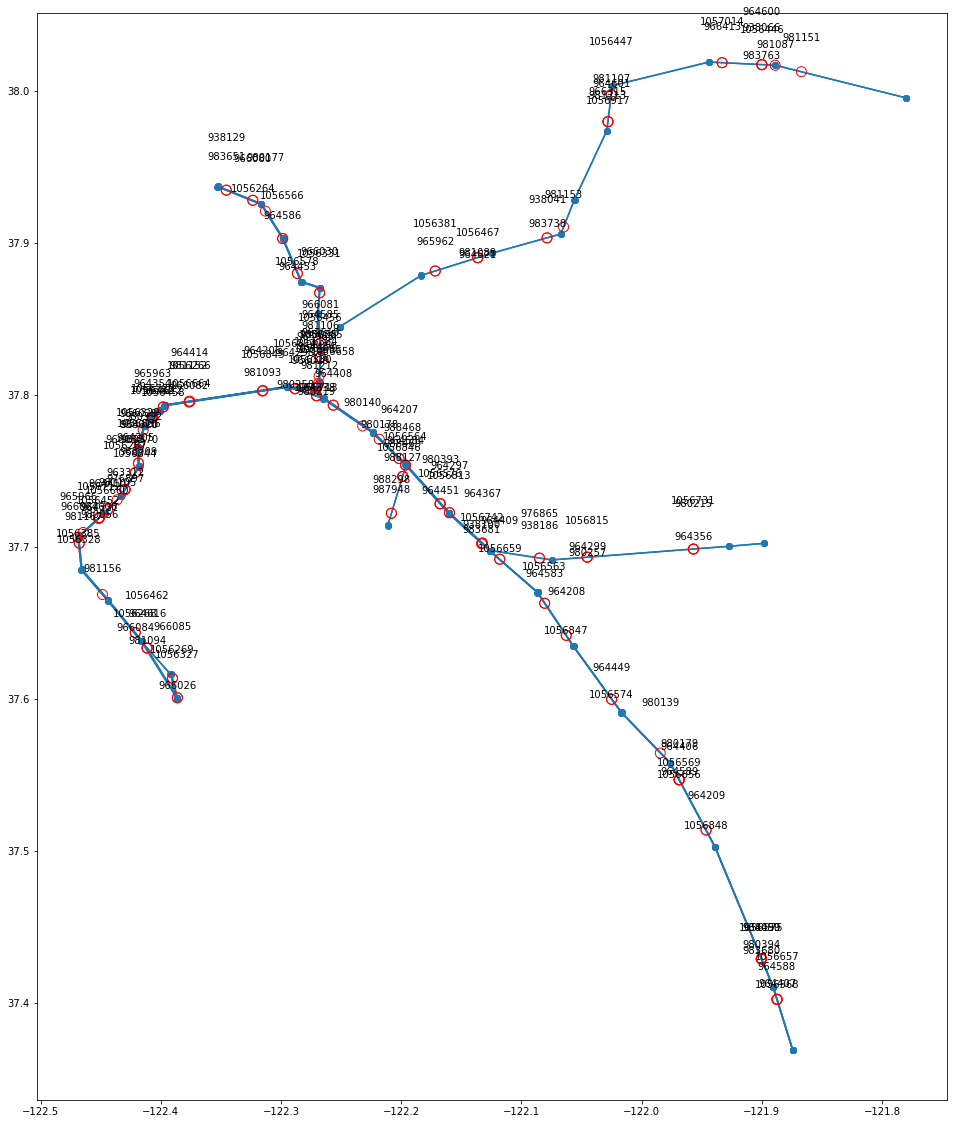

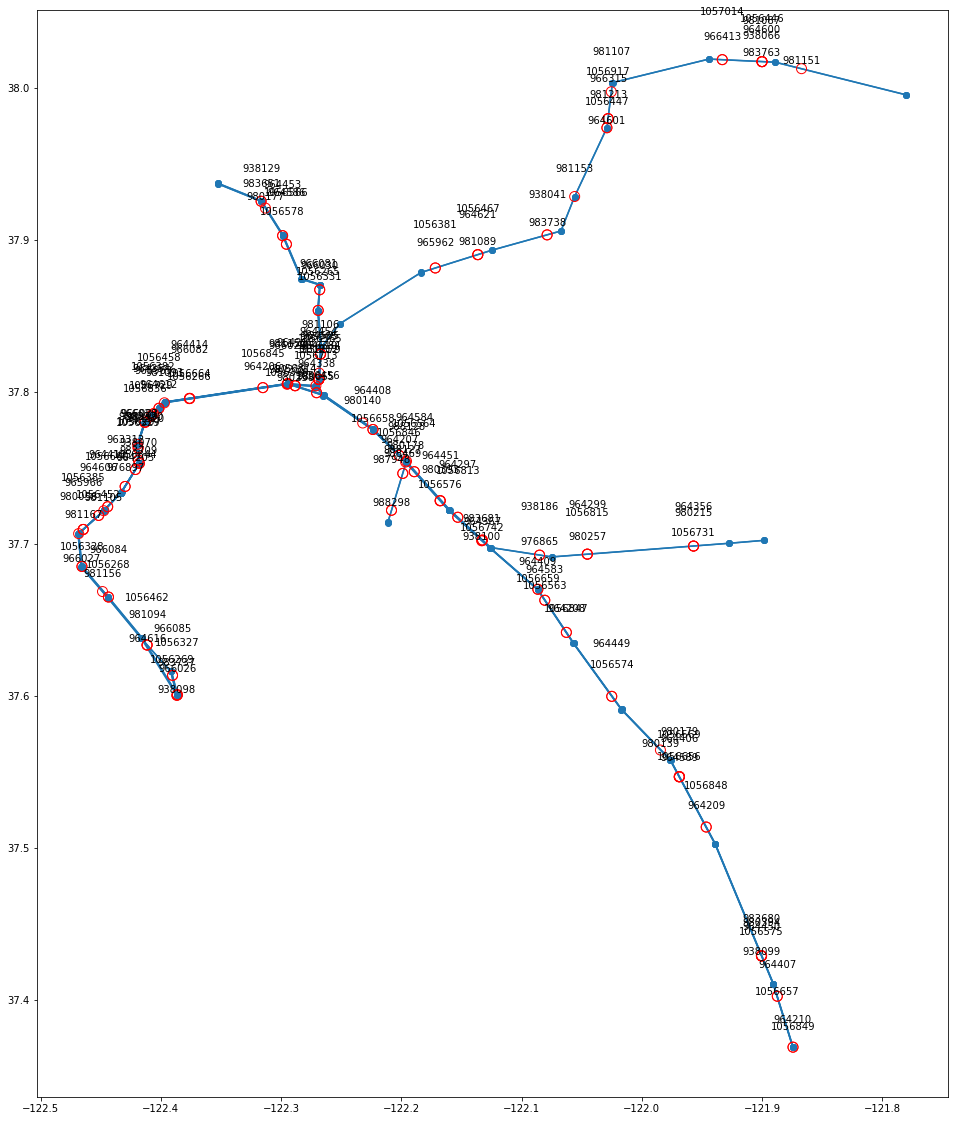

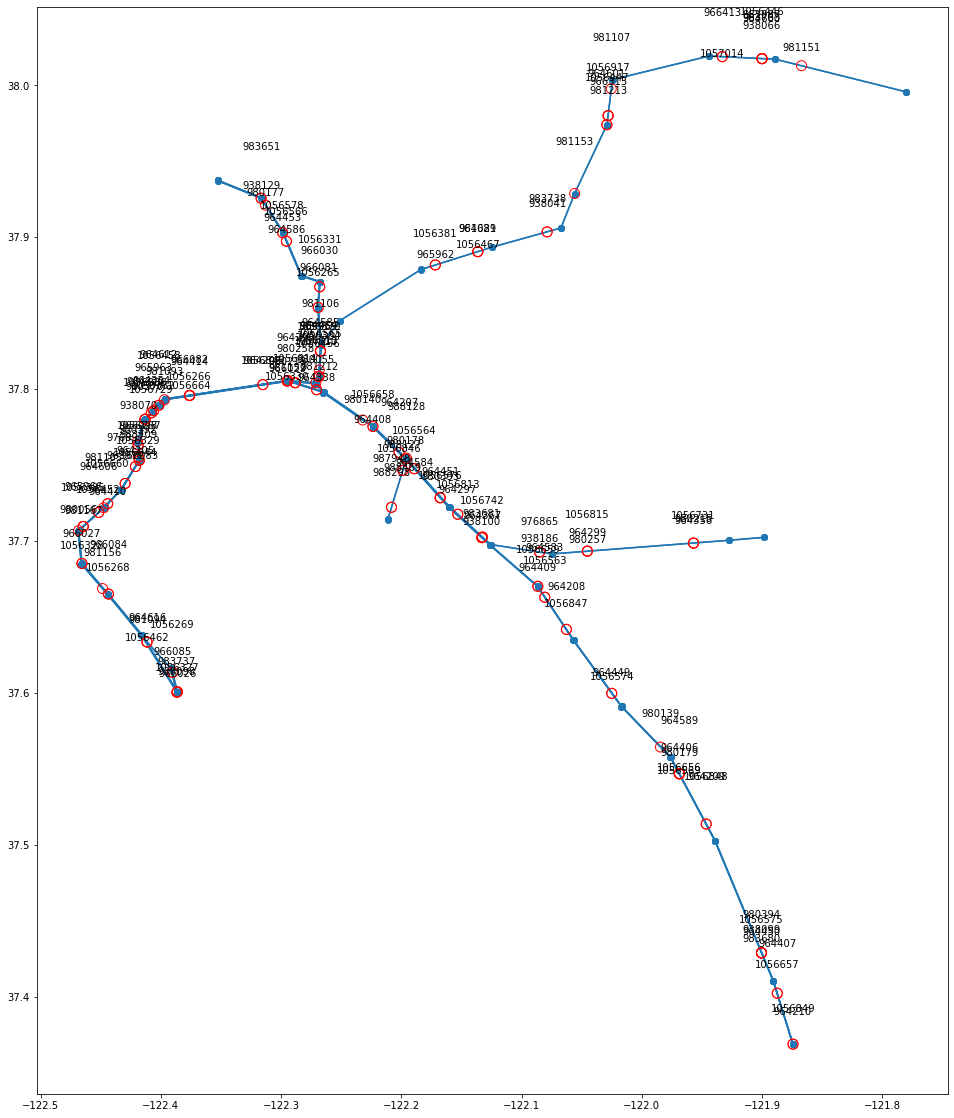

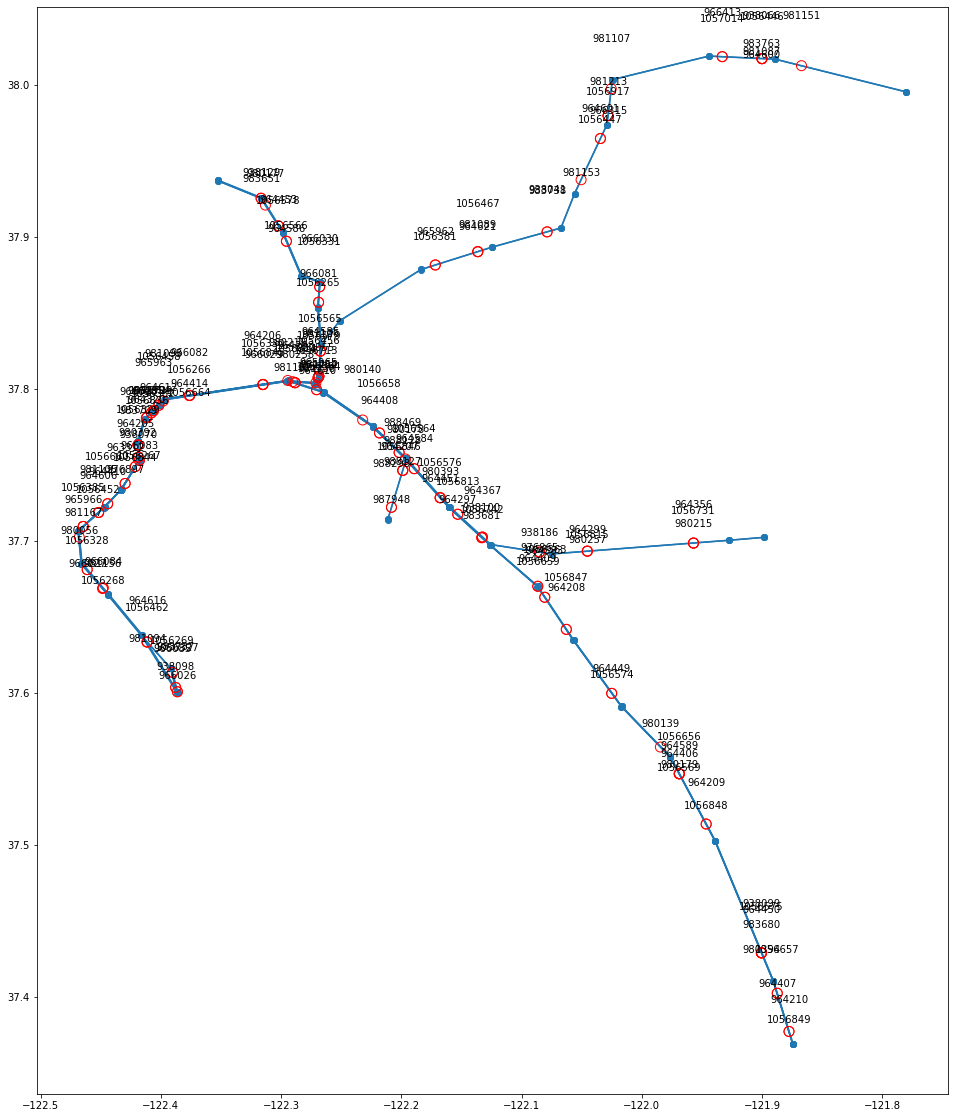

In [102]:
for t in range(26664, 26764, 20):
    ### update train location
    all_trains.update_location_occupancy(t)
    
    ### update traveler status
    #travelers.traveler_update(network, all_trains, t)
    
    ### print and plot results
    plot_map(network, all_trains, travelers, t)
        
    #break